# Global overview of benchmark results

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import os
from statsmodels.stats.multitest import multipletests
from pathlib import Path

pd.options.display.max_columns = 200

method_color_dict = {'ccube': '#548ebb', 'clonesig': '#fc9d53',
                     'deconstructsigs':'#793d66', 'palimpsest':'#e45683',
                     'pyclone': '#87d0bd', 'sciclone': '#e1f5aa',
                     'tracksig': '#c4c3f9', 'DPClust': '#90c9e8',
                    'PhylogicNDT': '#F3BEDF', 'tracksigfreq': '#8942fc'}
hatch_dict = {'prefit': '/', 'cancertype': '.', 'cancer_type': '.',
             'all': '', 'all_nuclonal': '+'}
sns.set_context("poster", font_scale=2)
mpl.rcParams['hatch.linewidth'] = 3
pd.options.display.max_columns = 200
os.chdir('..')
output_path = '20200515_paper_figures'
Path(output_path).mkdir(parents=True, exist_ok=True)
import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/Users/JudithAbecassis/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
legend_keys = {'ccube': 'Ccube', 'tracksig': 'TrackSig',
               'tracksigfreq': 'TrackSigFreq', 'pyclone': 'PyClone',
               'sciclone': 'SciClone', 'palimpsest': 'Palimpsest',
               'deconstructsigs': 'deconstructSigs',
               'PhylogicNDT': 'PhylogicNDT', 'DPClust': 'DPClust',
               'clonesig': 'CloneSig'}

In [4]:
dataset_names = ['CloneSigSim', 'DREAM', 'PhylogicSim500', 'SimClone1000']
res_filenames = ['20200520_eval_compare_simulations_cst.csv',
                 '20200525_dream_results.csv',
                 '20201011_phylo500_results.csv',
                 '20201011_simclone1000_results.csv']
id_vars_list = [['cancer_type', 'perc_diploid', 'nb_clones', 'nb_mut'],
                ['tumor', 'depth'],
                ['sample', 'var_or_cst'],
                ['sample', 'var_or_cst']]
nb_methods_list = [9, 8, 8, 8]

methods_to_use = ['deconstructsigs-cancertype', 'clonesig-cancer_type',
                  'palimpsest-cancertype', 'ccube-all', 'sciclone-all',
                  'pyclone-all', 'tracksig-cancertype', 'DPClust-all',
                  'PhylogicNDT-all', 'tracksigfreq-cancertype']

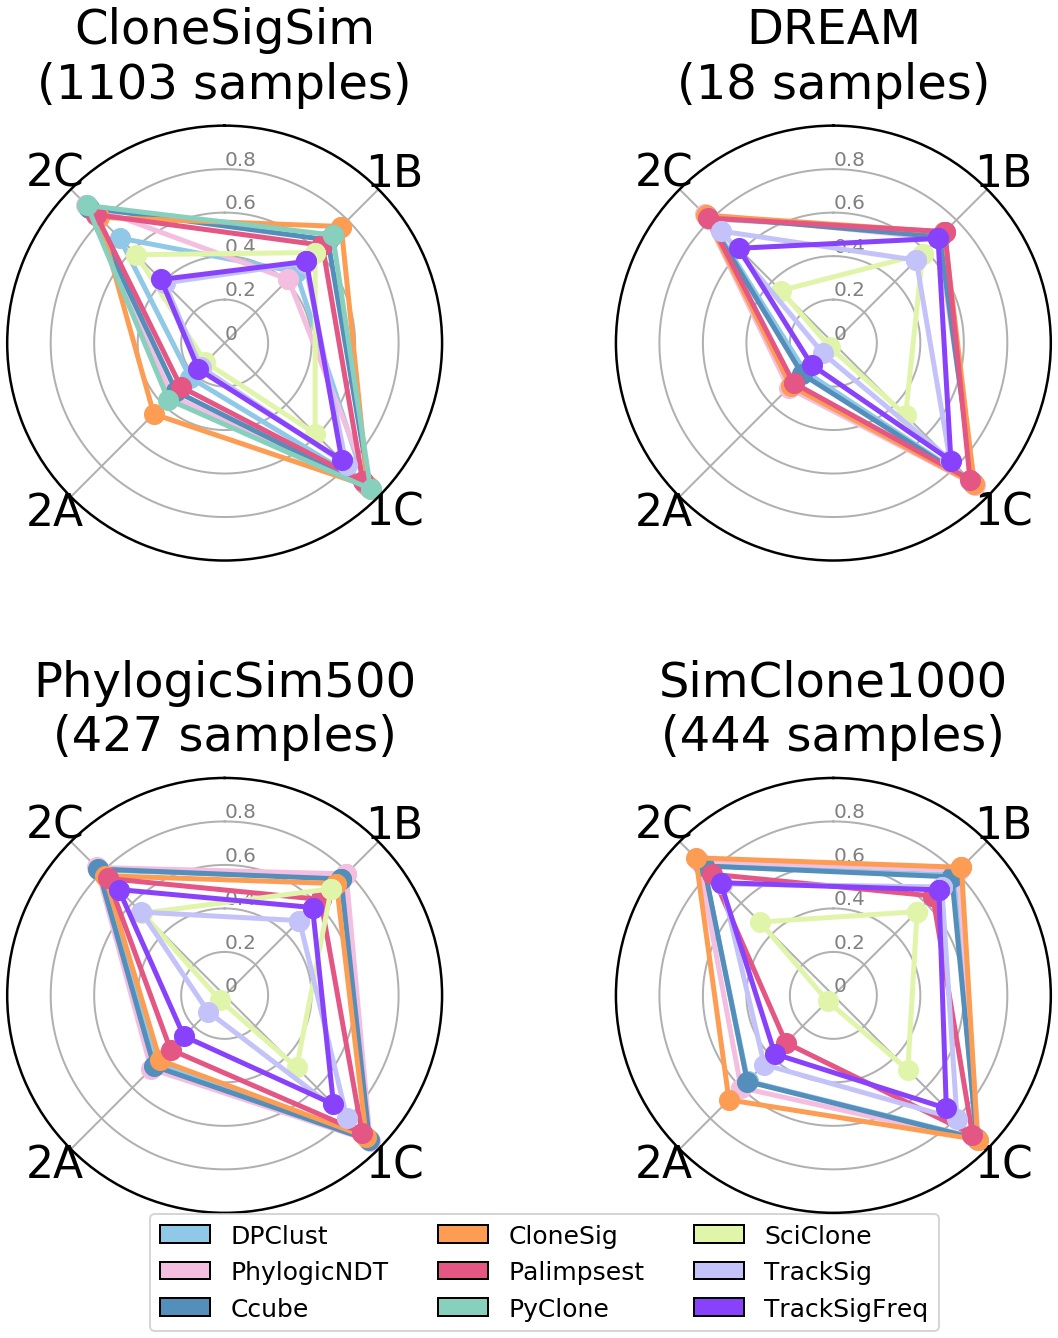

In [5]:
relevant_scores = ['score1B', 'score1C', 'score2A', 'score2C']
plt.figure(figsize=(20,20))
for did, dataset in enumerate(dataset_names):
    clonesig_res = pd.read_csv(res_filenames[did], sep='\t')
    clonesig_res = clonesig_res[~((clonesig_res.method=='tracksigfreq')&(clonesig_res.nb_mut<100))]
    if 'var_or_cst' in clonesig_res:
        clonesig_res = clonesig_res[clonesig_res.var_or_cst=='cst']
    if 'setting' in clonesig_res:
        clonesig_res = clonesig_res.assign(setting=clonesig_res.setting.fillna('all'))
    else:
        clonesig_res = clonesig_res.assign(setting='all')
        clonesig_res.loc[(clonesig_res.method=='clonesig'), 'setting'] = 'cancer_type'
        clonesig_res.loc[(clonesig_res.method.isin(('clonesig', 'palimpsest', 'tracksig', 'tracksigfreq')), 'setting')] = 'cancertype'
    clonesig_res.loc[clonesig_res.method=='dpclust', 'method'] = 'DPClust'
    clonesig_res.loc[clonesig_res.method=='phylogicndt', 'method'] = 'PhylogicNDT'
    clonesig_res.loc[(clonesig_res.setting=='cancertype')&(clonesig_res.method=='clonesig'), 'setting'] = 'cancer_type'
    clonesig_res = clonesig_res.assign(full_method=clonesig_res.method + '-' + clonesig_res.setting)
    reduced_clonesig_res = clonesig_res[clonesig_res.full_method.isin(methods_to_use)]
    if did==0:
        clonesig_res_ith = reduced_clonesig_res[reduced_clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'pyclone', 'tracksig', 'palimpsest', 'DPClust', 'PhylogicNDT', 'tracksigfreq'])]
    else:
        clonesig_res_ith = reduced_clonesig_res[reduced_clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'tracksig', 'palimpsest', 'DPClust', 'PhylogicNDT', 'tracksigfreq'])]
    clonesig_res_ith = clonesig_res_ith.assign(score2C=clonesig_res_ith.score2C_accuracy)

    id_vars = id_vars_list[did]

    aa = clonesig_res_ith.dropna(subset=relevant_scores).groupby(id_vars).method.nunique().to_frame().reset_index()
    aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
    sub_clonesig_res_complete = pd.merge(clonesig_res_ith.dropna(subset=relevant_scores), aa,
                                         on=id_vars)
    sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==nb_methods_list[did]]
    df = sub_clonesig_res_filter.groupby('full_method')[relevant_scores].mean()

    categories=list(df)
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [np.pi/4 + n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(2, 2, did+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], [c.replace('score', '') for c in categories])

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(np.linspace(0, 1, 6)[:-1], ['0', '0.2', '0.4', '0.6', '0.8'], color="grey", size=20)
    plt.ylim(0,1)

    #jiggle = np.linspace(-0.3, 0.3, 9)
    jiggle = np.linspace(-0.0, 0, 9)
    for i in range(nb_methods_list[did]):
        val=list(df.iloc[i].values)
        val += val[:1]
        ax.plot(np.array(angles) + jiggle[i], val, 'ob', ls='solid', color=method_color_dict[df.index[i].split('-')[0]], lw=5, markersize=20)

    nb_samples = sub_clonesig_res_filter.groupby('full_method')[relevant_scores].count().score1B.unique()[0]
    ax.set_title('{}\n({} samples)'.format(dataset, nb_samples))
    
    if did==0:
        legend_items = list()
        for key in sorted(sorted(clonesig_res_ith.method.unique())):
            legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='black', label=legend_keys[key]))
    if did==2:
        ax.legend(handles=legend_items,
                  bbox_to_anchor=(0.3, -0.3, 1., .102), fontsize=25, loc=3, ncol=3)

plt.subplots_adjust(hspace=0.5)
plt.savefig('{}/global_radar_chart_ith_cst.pdf'.format(output_path), bbox_inches='tight')


In [6]:
dataset_names = ['CloneSigSim', 'DREAM', 'PhylogicSim500', 'SimClone1000']
res_filenames = ['20200520_eval_compare_simulations_new.csv',
                 '20200525_dream_results.csv',
                 '20201011_phylo500_results.csv',
                 '20201011_simclone1000_results.csv']
id_vars_list = [['cancer_type', 'perc_diploid', 'nb_clones', 'nb_mut'],
                ['tumor', 'depth'],
                ['sample', 'var_or_cst'],
                ['sample', 'var_or_cst']]
nb_methods_list = [9, 8, 8, 8]

methods_to_use = ['deconstructsigs-cancertype', 'clonesig-cancer_type',
                  'palimpsest-cancertype', 'ccube-all', 'sciclone-all',
                  'pyclone-all', 'tracksig-cancertype', 'DPClust-all',
                  'PhylogicNDT-all', 'tracksigfreq-cancertype']

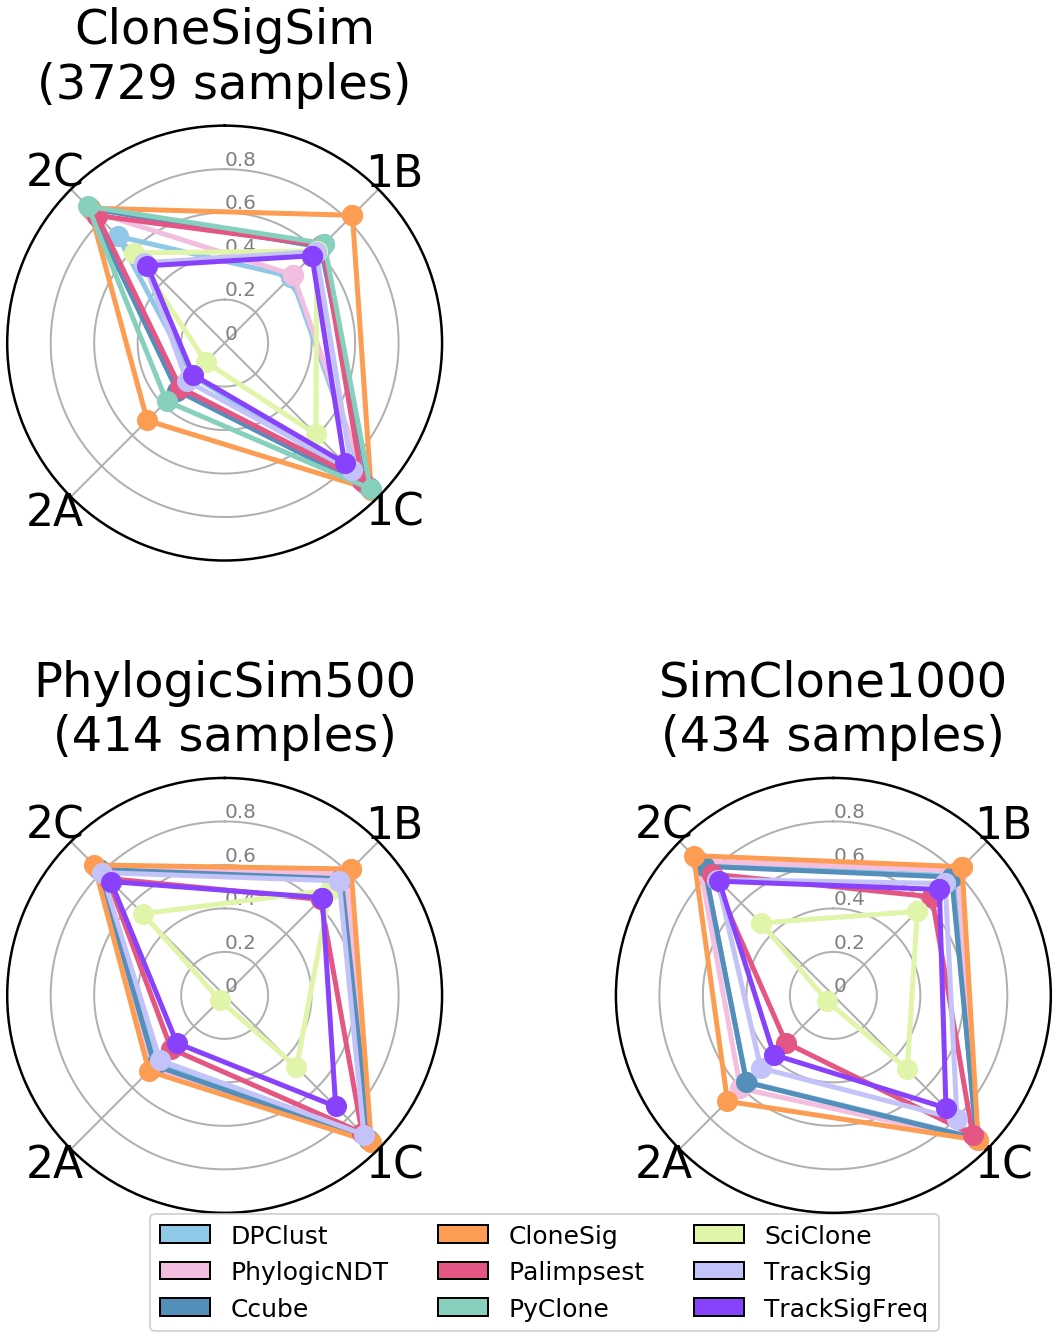

In [7]:
relevant_scores = ['score1B', 'score1C', 'score2A', 'score2C']
plt.figure(figsize=(20,20))
for did, dataset in enumerate(dataset_names):
    if did != 1:
        clonesig_res = pd.read_csv(res_filenames[did], sep='\t')
        clonesig_res = clonesig_res[~((clonesig_res.method=='tracksigfreq')&(clonesig_res.nb_mut<100))]
        if 'var_or_cst' in clonesig_res:
            clonesig_res = clonesig_res[clonesig_res.var_or_cst=='var']
        if 'setting' in clonesig_res:
            clonesig_res = clonesig_res.assign(setting=clonesig_res.setting.fillna('all'))
        else:
            clonesig_res = clonesig_res.assign(setting='all')
            clonesig_res.loc[(clonesig_res.method=='clonesig'), 'setting'] = 'cancer_type'
            clonesig_res.loc[(clonesig_res.method.isin(('clonesig', 'palimpsest', 'tracksig', 'tracksigfreq')), 'setting')] = 'cancertype'
        clonesig_res.loc[clonesig_res.method=='dpclust', 'method'] = 'DPClust'
        clonesig_res.loc[clonesig_res.method=='phylogicndt', 'method'] = 'PhylogicNDT'
        clonesig_res.loc[(clonesig_res.setting=='cancertype')&(clonesig_res.method=='clonesig'), 'setting'] = 'cancer_type'
        clonesig_res = clonesig_res.assign(full_method=clonesig_res.method + '-' + clonesig_res.setting)
        reduced_clonesig_res = clonesig_res[clonesig_res.full_method.isin(methods_to_use)]
        if did==0:
            clonesig_res_ith = reduced_clonesig_res[reduced_clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'pyclone', 'tracksig', 'palimpsest', 'DPClust', 'PhylogicNDT', 'tracksigfreq'])]
        else:
            clonesig_res_ith = reduced_clonesig_res[reduced_clonesig_res.method.isin(['ccube', 'clonesig', 'sciclone', 'tracksig', 'palimpsest', 'DPClust', 'PhylogicNDT', 'tracksigfreq'])]
        clonesig_res_ith = clonesig_res_ith.assign(score2C=clonesig_res_ith.score2C_accuracy)

        id_vars = id_vars_list[did]

        aa = clonesig_res_ith.dropna(subset=relevant_scores).groupby(id_vars).method.nunique().to_frame().reset_index()
        aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
        sub_clonesig_res_complete = pd.merge(clonesig_res_ith.dropna(subset=relevant_scores), aa,
                                             on=id_vars)
        sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==nb_methods_list[did]]
        df = sub_clonesig_res_filter.groupby('full_method')[relevant_scores].mean()

        categories=list(df)
        N = len(categories)

        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [np.pi/4 + n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]

        # Initialise the spider plot
        ax = plt.subplot(2, 2, did+1, polar=True)

        # If you want the first axis to be on top:
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], [c.replace('score', '') for c in categories])

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(np.linspace(0, 1, 6)[:-1], ['0', '0.2', '0.4', '0.6', '0.8'], color="grey", size=20)
        plt.ylim(0,1)

        #jiggle = np.linspace(-0.3, 0.3, 9)
        jiggle = np.linspace(-0.0, 0, 9)
        for i in range(nb_methods_list[did]):
            val=list(df.iloc[i].values)
            val += val[:1]
            ax.plot(np.array(angles) + jiggle[i], val, 'ob', ls='solid', color=method_color_dict[df.index[i].split('-')[0]], lw=5, markersize=20)

        nb_samples = sub_clonesig_res_filter.groupby('full_method')[relevant_scores].count().score1B.unique()[0]
        ax.set_title('{}\n({} samples)'.format(dataset, nb_samples))

        if did==0:
            legend_items = list()
            for key in sorted(sorted(clonesig_res_ith.method.unique())):
                legend_items.append(Patch(facecolor=method_color_dict[key], edgecolor='black', label=legend_keys[key]))
        if did==2:
            ax.legend(handles=legend_items,
                      bbox_to_anchor=(0.3, -0.3, 1., .102), fontsize=25, loc=3, ncol=3)

plt.subplots_adjust(hspace=0.5)
plt.savefig('{}/global_radar_chart_ith_var.pdf'.format(output_path), bbox_inches='tight')


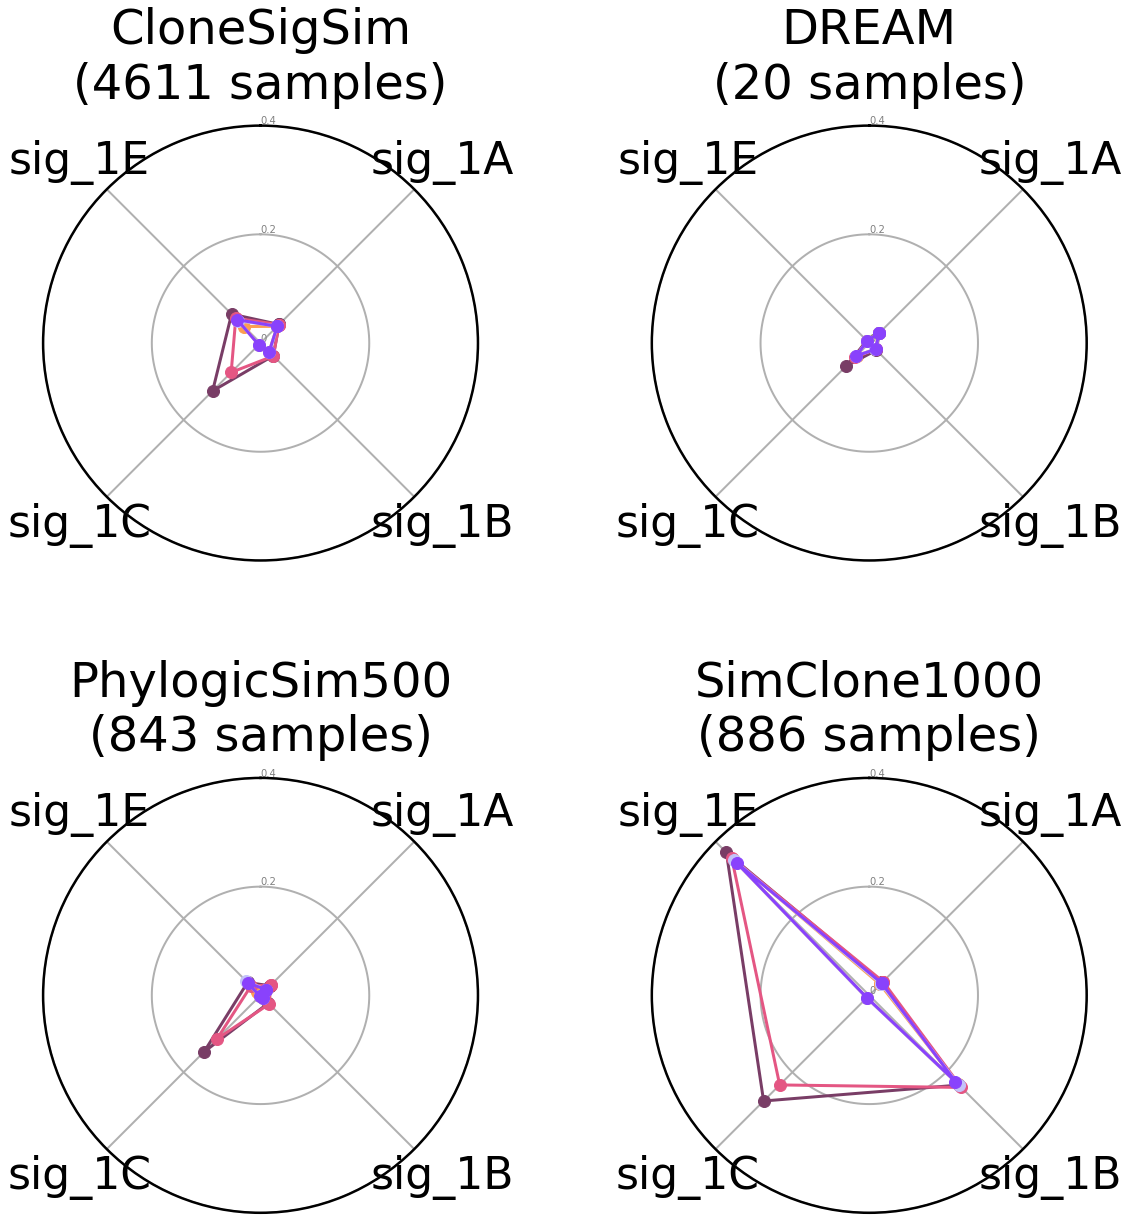

In [8]:
relevant_scores = ['score_sig_1A', 'score_sig_1B', 'score_sig_1C',
                   'score_sig_1E']
plt.figure(figsize=(20,20))
for did, dataset in enumerate(dataset_names):
    if did != 9:
        clonesig_res = pd.read_csv(res_filenames[did], sep='\t')
        clonesig_res = clonesig_res.assign(score_sig_1E=clonesig_res.median_diff_distrib_mut)
        clonesig_res = clonesig_res.assign(score_sig_1C=1-clonesig_res.score_sig_1C_auc)
        clonesig_res = clonesig_res[~((clonesig_res.method=='tracksigfreq')&(clonesig_res.nb_mut<100))]
        if 'setting' in clonesig_res:
            clonesig_res = clonesig_res.assign(setting=clonesig_res.setting.fillna('all'))
        else:
            clonesig_res = clonesig_res.assign(setting='all')
            clonesig_res.loc[(clonesig_res.method=='clonesig'), 'setting'] = 'cancer_type'
            clonesig_res.loc[(clonesig_res.method.isin(('clonesig', 'palimpsest', 'tracksig', 'tracksigfreq', 'deconstructsigs')), 'setting')] = 'cancertype'
        clonesig_res.loc[clonesig_res.method=='dpclust', 'method'] = 'DPClust'
        clonesig_res.loc[clonesig_res.method=='phylogicndt', 'method'] = 'PhylogicNDT'
        clonesig_res.loc[(clonesig_res.setting=='cancertype')&(clonesig_res.method=='clonesig'), 'setting'] = 'cancer_type'
        clonesig_res = clonesig_res.assign(full_method=clonesig_res.method + '-' + clonesig_res.setting)
        reduced_clonesig_res = clonesig_res[clonesig_res.full_method.isin(methods_to_use)]
        clonesig_res_sig = reduced_clonesig_res[reduced_clonesig_res.method.isin(['clonesig', 'deconstructsigs', 'tracksig', 'palimpsest', 'tracksigfreq'])]


        id_vars = id_vars_list[did]

        aa = clonesig_res_sig.dropna(subset=relevant_scores).groupby(id_vars).method.nunique().to_frame().reset_index()
        aa = aa.assign(nb_method=aa.method).drop(columns=['method'])
        sub_clonesig_res_complete = pd.merge(clonesig_res_sig.dropna(subset=relevant_scores), aa,
                                             on=id_vars)
        sub_clonesig_res_filter = sub_clonesig_res_complete[sub_clonesig_res_complete.nb_method==5]
        df = sub_clonesig_res_filter.groupby('full_method')[relevant_scores].mean()

        categories=list(df)
        N = len(categories)

        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        angles = [np.pi/4 + n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]

        # Initialise the spider plot
        ax = plt.subplot(2, 2, did+1, polar=True)

        # If you want the first axis to be on top:
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels labels yet
        ax.tick_params(axis='x', which='major', pad=20)
        plt.xticks(angles[:-1], [c.replace('score_', '') for c in categories])

        # Draw ylabels
        ax.set_rlabel_position(0)
        plt.yticks(np.linspace(0, 0.4, 3), ['0', '0.2', '0.4'], color="grey", size=10)
        plt.ylim(0,0.4)

        #jiggle = np.linspace(-0.3, 0.3, 9)
        jiggle = np.linspace(-0.0, 0, 9)
        for i in range(5):
            val=list(df.iloc[i].values)
            val += val[:1]
            ax.plot(np.array(angles) + jiggle[i], val, 'ob', ls='solid', color=method_color_dict[df.index[i].split('-')[0]])

        nb_samples = sub_clonesig_res_filter.groupby('full_method')[relevant_scores].count().score_sig_1A.unique()[0]
        ax.set_title('{}\n({} samples)'.format(dataset, nb_samples))
plt.subplots_adjust(hspace=0.5)